# 멀티 에이전트

- 멀티 에이전트 네트워크를 LangGraph를 활용하여 구현하는 방법
- 멀티 에이전트 네트워크는 복잡한 작업을 여러 개의 전문화된 에이전트들로 나누어 처리하는 "분할 정복" 접근 방식을 사용하는 아키텍처
- 이를 통해 단일 에이전트가 많은 도구를 비효율적으로 사용하는 문제를 해결하고, 각 에이전트가 자신의 전문 분야에서 효과적으로 문제를 해결

<!-- ![alt text]() -->

<img src="images/multi-agent_2.png" alt="이미지 설명" width="600" />

##  멀티 에이전트 사용하는 이유

단일 에이전트는 특정 도메인 내에서 일정 수의 도구를 사용할 때 효율적이나 한 에이전트가 너무 많은 도구를 다루면 아래 문제 발생

1. 도구 사용 로직이 복잡해짐
2. 에이전트가 한 번에 처리해야 할 정보 양이 증가하여 비효율적임


이에 멀티에이전트를 활용하면,


- "분할 정복" 접근을 사용하면 각 에이전트는 특정 업무나 전문성 영역에 집중할 수 있고, 전체 작업이 네트워크 형태로 나뉘어 처리
- 각 에이전트는 자신이 잘하는 일을 처리하고, 필요 시 해당 업무를 다른 전문 에이전트에게 위임하거나 도구를 적절히 활용

**주요 참고 자료**  
- [LangGraph 멀티 에이전트 네트워크 개념](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network)  
- [AutoGen 논문: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)  

![alt text](images/multi-agent.png)

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

이번 에이전트에 사용할 모델명을 지정합니다.

In [2]:
# 최신 모델 이름 가져오기
MODEL_NAME = "gpt-4o"

print(MODEL_NAME)

gpt-4o


## 상태 정의

`messages` 는 Agent 간 공유하는 메시지 목록이며, `sender` 는 마지막 메시지의 발신자입니다.

In [3]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # Agent 간 공유하는 메시지 목록
    sender: Annotated[str, "The sender of the last message"]  # 마지막 메시지의 발신자

## 도구 정의

에이전트가 앞으로 사용할 몇 가지 도구를 정의합니다.

- `TavilySearch` 는 인터넷에서 정보를 검색하는 도구입니다. `Research Agent` 가 필요한 정보를 검색할 때 사용합니다.
- `PythonREPL` 는 Python 코드를 실행하는 도구입니다. `Chart Generator Agent` 가 차트를 생성할 때 사용합니다.

In [4]:
from typing import Annotated

from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 검색 도구 정의
tavily_tool = TavilySearch(max_results=5)

# Python 코드를 실행하는 도구 정의
python_repl = PythonREPL()


# Python 코드를 실행하는 도구 정의
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # 주어진 코드를 Python REPL에서 실행하고 결과 반환
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"
    # 실행 성공 시 결과와 함께 성공 메시지 반환
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## 에이전트 생성

### Research Agent

`TavilySearch` 도구를 사용하여 연구를 수행하는 에이전트를 생성합니다. 이 에이전트를 필요한 정보를 리서치하는 데 사용합니다.

In [5]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [6]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

# LLM 정의
llm = ChatOpenAI(model=MODEL_NAME)

# Research Agent 생성
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


# Research Agent 노드 정의
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        # Research Agent 의 메시지 목록 반환
        "messages": [last_message],
    }

### Chart Generator Agent

`PythonREPL` 도구를 사용하여 차트를 생성하는 에이전트를 생성합니다. 이 에이전트를 차트를 생성하는 데 사용합니다.

In [7]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""

# Chart Generator Agent 생성
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(chart_generator_system_prompt),
)

In [8]:
def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        # share internal message history of chart agent with other agents
        "messages": [last_message],
    }

In [9]:
from langgraph.graph import END


def router(state: MessagesState):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

## 그래프 생성

### 에이전트 노드 및 엣지 정의

이제 노드를 정의해야 합니다. 먼저, 에이전트에 대한 노드를 정의합니다.

In [10]:
from langchain_core.messages import HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())

생성한 그래프 시각화를 진행합니다.

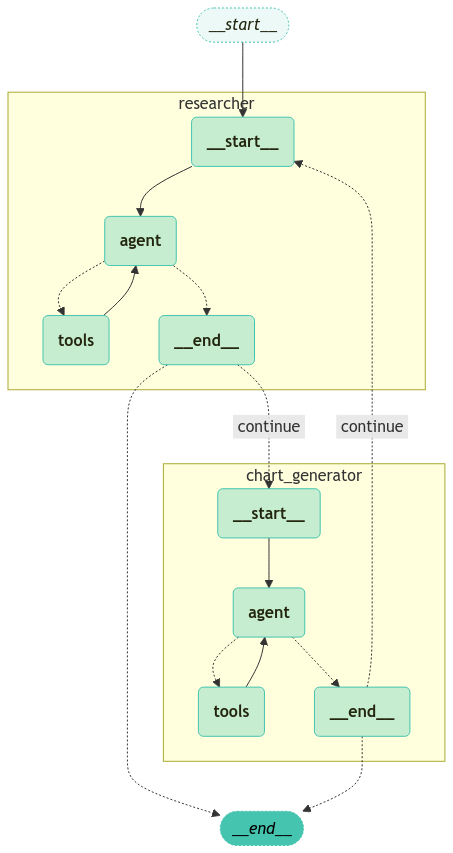

In [11]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)


🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_moidWeLgn9R2xysEMAG45gJL)
 Call ID: call_moidWeLgn9R2xysEMAG45gJL
  Args:
    query: 2000년부터 2023년까지 한국의 GDP 성장률
  tavily_web_search (call_Oyv4HK1JYysKUEwNYVRnM3Qk)
 Call ID: call_Oyv4HK1JYysKUEwNYVRnM3Qk
  Args:
    query: GDP growth rate South Korea 2000 to 2023

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

대한민국의 GDP 성장률에 대한 정보를 수집했습니다. 아래는 2000년부터 2023년까지의 한국 GDP 성장률 데이터입니다:

- 2000년: 9.06%
- 2001년: 4.85%
- 2002년: 7.73%
- 2003년: 3.15%
- 2004년: 5.20%
- 2005년: 4.31%
- 2006년: 5.26%
- 2007년: 5.80%
- 2008년: 3.01%
- 2009년: 0.79%
- 2010년: 6.80%
- 2011년: 3.69%
- 2012년: 2.40%
- 2013년: 3.16%
- 2014년: 3.20%
- 2015년: 2.81%
- 2016년: 2.95%
- 2017년: 3.16%
- 2018년: 2.91%
- 2019년: 2

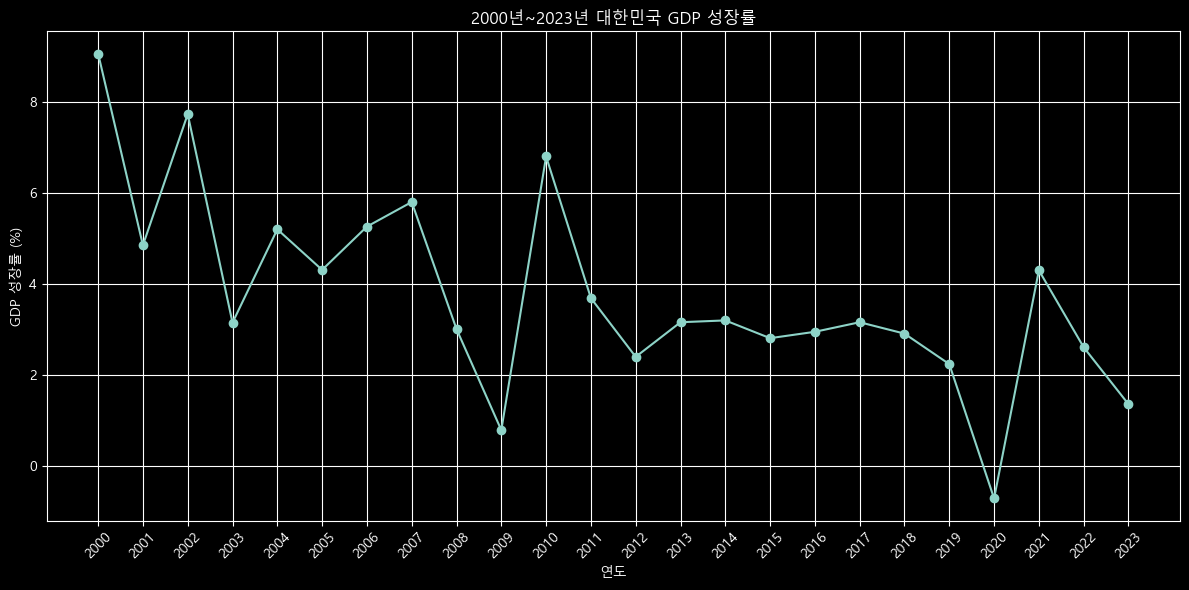


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

FINAL ANSWER: 2000년부터 2023년까지의 대한민국 GDP 성장률 그래프가 성공적으로 생성되었습니다. 이 그래프는 각 연도별 GDP 성장률의 변화를 시각적으로 잘 보여줍니다.

🔄 Node: chart_generator 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: chart_generator

FINAL ANSWER: 2000년부터 2023년까지의 대한민국 GDP 성장률 그래프가 성공적으로 생성되었습니다. 이 그래프는 각 연도별 GDP 성장률의 변화를 시각적으로 잘 보여줍니다.


In [18]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            # content="2024년의 달러원환율을 월단위 평균으로 표현해주세요."
            content="2000년~2023년까지의 대한민국의 GDP 성장률을 그려주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])